In [3]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, RepeatVector
import tensorflow as tf
import os
from keras.layers import TimeDistributed
import matplotlib.pyplot as plt
import urllib.request
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import keras
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding

In [4]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
"""
New Data
"""
#data = pd.read_csv("curvy_data.csv")
data = pd.read_csv("traj_data_v2.csv")
data.describe()

,Unnamed: 0,Vehicle_ID,X,Y,X_REL,Y_REL
count,307834.00000,307834.000000,307834.000000,307834.000000,3.078340e+05,3.078340e+05
mean,153916.50000,153892.000884,151.187971,-33.894347,4.361413e-07,4.547582e-07
std,88864.16572,88864.166079,0.002386,0.001482,2.208221e-05,1.067770e-05
min,0.00000,0.000000,151.184833,-33.895620,-6.331820e-05,-4.471060e-05
25%,76958.25000,76950.000000,151.186520,-33.895157,-1.109110e-05,-5.980100e-06
50%,153916.50000,153900.000000,151.187506,-33.894778,0.000000e+00,0.000000e+00
75%,230874.75000,230850.000000,151.188627,-33.894293,1.225900e-05,7.062200e-06
max,307833.00000,307800.000000,151.194606,-33.888825,6.605090e-05,4.435870e-05


In [6]:
len(data['Vehicle_ID'].unique())

6157

In [7]:
"""
Preprocess data, removed torch tensors return type, now np arrays
"""
def preprocess_dataset(data, max = 10, max_len = 40, input_len = 30):
    scaler = MinMaxScaler(feature_range=(0, max))
    data[['X_REL', 'Y_REL']] = scaler.fit_transform(data[['X_REL', 'Y_REL']])
    global map_dict
    map_dict = {}
    unique_peds = data['Vehicle_ID'].unique()
    unique_peds = sorted(unique_peds)
    inputs = []
    indexes = []
    outputs = []
    seq = []
    for ped in unique_peds:
        if (len(data[data['Vehicle_ID'] == ped]) >= max_len):
          indexes.append(ped)
          seq_inner = []
          target_inner = 0
          i = 0
          for indx, row in data[data['Vehicle_ID'] == ped].iterrows():
            x = round(row['X_REL'])
            y = round(row['Y_REL'])
            ## Cantor pairing function:
            bin = y * max + x
            #print("X: ", x, " Y: ", y, " Bin: ", bin)
            map_dict[int(bin)] = [int(x), int(y)]
            i += 1
            if i == max_len:
              break
            seq_inner.append(int(bin))
          inputs.append([seq_inner[0:input_len]])
          outputs.append([seq_inner[input_len + 1:]])
    train_inputs, test_inputs = train_test_split(inputs, train_size=0.7)
    train_inputs, test_inputs, train_targets, test_targets = train_test_split(inputs, outputs, train_size=0.8)
    
    return np.array(train_inputs), np.array(test_inputs), np.array(train_targets), np.array(test_targets)

In [8]:
train_data_inputs, test_data_inputs, train_data_targets, test_data_targets = preprocess_dataset(data, max = 100, max_len = 50, input_len = 20)

In [9]:
print(train_data_inputs.shape)
print(train_data_targets.shape)
train_data_inputs = train_data_inputs.reshape(train_data_inputs.shape[0], train_data_inputs.shape[2], 1)
train_data_targets = train_data_targets.reshape(train_data_targets.shape[0], train_data_targets.shape[2], 1)
print(train_data_inputs.shape)
print(train_data_targets.shape)

(4924, 1, 20)
(4924, 1, 28)
(4924, 20, 1)
(4924, 28, 1)


In [10]:
print(test_data_inputs.shape)
print(test_data_targets.shape)
test_data_inputs = test_data_inputs.reshape(test_data_inputs.shape[0], test_data_inputs.shape[2], 1)
test_data_targets = test_data_targets.reshape(test_data_targets.shape[0], test_data_targets.shape[2], 1)
print(test_data_inputs.shape)
print(test_data_targets.shape)

(1232, 1, 20)
(1232, 1, 28)
(1232, 20, 1)
(1232, 28, 1)


In [11]:
"""
def plot_prediction(test_index = 0, scaled = False):
  m = my_max
  i = inputs_scaled
  o = outputs_scaled
  if scaled == False:
    m = 1
    i = inputs
    o = outputs
  print(m)
  test_ind = test_index
  t = i[test_ind]
  t = t.reshape(1, 12, 2)
  b = model.predict(t)
  b = np.squeeze(b)
  xx = b[:,0] * m
  yy = b[:,1] * m
  check_tar = o[test_ind] * m
  check_input = i[test_ind] * m
  plt.plot(xx, yy, 'ro')
  plt.plot(check_tar[:,0], check_tar[:,1], 'bo')
  plt.plot(check_input[:,0], check_input[:,1])
"""

"\ndef plot_prediction(test_index = 0, scaled = False):\n  m = my_max\n  i = inputs_scaled\n  o = outputs_scaled\n  if scaled == False:\n    m = 1\n    i = inputs\n    o = outputs\n  print(m)\n  test_ind = test_index\n  t = i[test_ind]\n  t = t.reshape(1, 12, 2)\n  b = model.predict(t)\n  b = np.squeeze(b)\n  xx = b[:,0] * m\n  yy = b[:,1] * m\n  check_tar = o[test_ind] * m\n  check_input = i[test_ind] * m\n  plt.plot(xx, yy, 'ro')\n  plt.plot(check_tar[:,0], check_tar[:,1], 'bo')\n  plt.plot(check_input[:,0], check_input[:,1])\n"

In [12]:
def make_one_hot(inp):
  result = []
  for i in inp:
    inner = []
    for bin in i:
      one_hot_vector = np.zeros(((100*100) + 50), dtype= np.uint16)
      one_hot_vector[bin] = 1
      inner.append(one_hot_vector)
    result.append(inner)
  return np.array(result)

In [13]:
ti = make_one_hot(train_data_inputs)
tt = make_one_hot(train_data_targets)
val_in = make_one_hot(test_data_inputs) 
val_tar = make_one_hot(test_data_targets)

In [14]:
print(ti.nbytes)
print(tt.nbytes)
print(val_in.nbytes)
print(val_tar.nbytes)

1979448000
2771227200
495264000
693369600


In [15]:
print(ti.shape)
print(tt.shape)
n = 1
while(n < 4924):
  if(4924 % n == 0):
    print(n)
  n += 1

(4924, 20, 10050)
(4924, 28, 10050)
1
2
4
1231
2462


In [16]:
print(val_in.shape, val_tar.shape)

(1232, 20, 10050) (1232, 28, 10050)


In [17]:
vocab_size = (100 * 100) + 50
input_len = 20
target_len = 28
train_inputs = ti
train_targets =tt
test_inputs = val_in
test_targets = val_tar

In [23]:
#here both inp and tar must be same length
"""
model = Sequential()
model.add(LSTM(50, batch_input_shape=(1, input_len, vocab_size), return_sequences=True, stateful=True))
model.add(LSTM(50, batch_input_shape=(1, target_len, vocab_size), return_sequences=True, stateful=True))
model.add(TimeDistributed(Dense(vocab_size, activation='softmax')))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
"""

"\nmodel = Sequential()\nmodel.add(LSTM(50, batch_input_shape=(1, input_len, vocab_size), return_sequences=True, stateful=True))\nmodel.add(LSTM(50, batch_input_shape=(1, target_len, vocab_size), return_sequences=True, stateful=True))\nmodel.add(TimeDistributed(Dense(vocab_size, activation='softmax')))\nmodel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])\n"

In [18]:
#this model used
#https://machinelearningmastery.com/how-to-use-an-encoder-decoder-lstm-to-echo-sequences-of-random-integers/
model = Sequential()
model.add(LSTM(250, batch_input_shape=(4, input_len, vocab_size), activation='tanh', stateful=True, dropout=0.1))
model.add(RepeatVector(target_len))
model.add(LSTM(250, return_sequences=True, activation='tanh', stateful=True, dropout=0.1))
model.add(TimeDistributed(Dense(vocab_size, activation='softmax')))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (4, 250)                  10301000  
_________________________________________________________________
repeat_vector (RepeatVector) (4, 28, 250)              0         
_________________________________________________________________
lstm_1 (LSTM)                (4, 28, 250)              501000    
_________________________________________________________________
time_distributed (TimeDistri (4, 28, 10050)            2522550   
Total params: 13,324,550
Trainable params: 13,324,550
Non-trainable params: 0
_________________________________________________________________


In [20]:
history = model.fit(
    train_inputs,
    train_targets,
    batch_size=4,
    epochs=20,
    validation_data=(test_inputs, test_targets)
)

Epoch 1/20
1231/1231 [==============================] - 25s 20ms/step - loss: 6.3199 - accuracy: 0.0760 - val_loss: 5.4726 - val_accuracy: 0.0975
Epoch 2/20
1231/1231 [==============================] - 24s 19ms/step - loss: 5.0116 - accuracy: 0.1042 - val_loss: 4.6888 - val_accuracy: 0.1323
Epoch 3/20
1231/1231 [==============================] - 25s 20ms/step - loss: 4.3929 - accuracy: 0.1338 - val_loss: 4.0740 - val_accuracy: 0.1582
Epoch 4/20
1231/1231 [==============================] - 25s 20ms/step - loss: 3.9238 - accuracy: 0.1608 - val_loss: 3.6082 - val_accuracy: 0.1989
Epoch 5/20
1231/1231 [==============================] - 25s 20ms/step - loss: 3.4659 - accuracy: 0.1946 - val_loss: 3.1730 - val_accuracy: 0.2439
Epoch 6/20
1231/1231 [==============================] - 25s 20ms/step - loss: 3.1395 - accuracy: 0.2266 - val_loss: 2.8919 - val_accuracy: 0.2662
Epoch 7/20
1231/1231 [==============================] - 24s 19ms/step - loss: 2.8601 - accuracy: 0.2552 - val_loss: 2.6774 -

KeyboardInterrupt: 

In [29]:
model.save('new.h5')

In [30]:
restored_model = keras.models.load_model('new.h5')
restored_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [25]:
history = new_model.fit(
    train_inputs,
    train_targets,
    batch_size=4,
    epochs=10,
    validation_data=(test_inputs, test_targets)
)

Epoch 1/10
1231/1231 [==============================] - 24s 19ms/step - loss: 1.0981 - accuracy: 0.5923 - val_loss: 1.4364 - val_accuracy: 0.5448
Epoch 2/10
1231/1231 [==============================] - 24s 20ms/step - loss: 1.1236 - accuracy: 0.5887 - val_loss: 1.4567 - val_accuracy: 0.5425
Epoch 3/10
1231/1231 [==============================] - 24s 19ms/step - loss: 1.1168 - accuracy: 0.5904 - val_loss: 1.4379 - val_accuracy: 0.5475
Epoch 4/10
1231/1231 [==============================] - 24s 20ms/step - loss: 1.1096 - accuracy: 0.5933 - val_loss: 1.4781 - val_accuracy: 0.5471
Epoch 5/10
1231/1231 [==============================] - 24s 20ms/step - loss: 1.1027 - accuracy: 0.5950 - val_loss: 1.4382 - val_accuracy: 0.5518
Epoch 6/10
1231/1231 [==============================] - 24s 19ms/step - loss: 1.0897 - accuracy: 0.5994 - val_loss: 1.3934 - val_accuracy: 0.5632
Epoch 7/10
1231/1231 [==============================] - 24s 19ms/step - loss: 1.0824 - accuracy: 0.6015 - val_loss: 1.4250 -

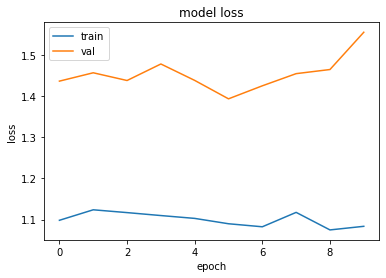

In [27]:
#plotting losses, https://stackoverflow.com/questions/41908379/keras-plot-training-validation-and-test-set-accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [26]:
new_model.save('LSTM_60acc_best.h5')
new_model.save_weights('./best_model_w')



In [49]:
model = tf.keras.models.load_model('LSTM_60acc_best.h5')
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model = Sequential()
model.add(LSTM(100, batch_input_shape=(4, input_len, vocab_size), stateful=True))
model.add(RepeatVector(target_len))
model.add(LSTM(100, return_sequences=True, stateful=True))
model.add(LSTM(100, return_sequences=True, stateful=True))
model.add(TimeDistributed(Dense(vocab_size, activation='softmax')))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [250]:
input_len = 20
target_len = 28
train_inputs = ti
train_targets =tt
test_inputs = val_in
test_targets = val_tar

In [267]:
def get_predictions(model, data_source_inputs, data_source_targets):

    predictions = []
    ground_truths = []
    inputs = [] #this is input seq alrdy

    #batch size 4 means we must predict in batches of 4 (keras/tf limitation)
    for i in range(0, data_source_inputs.shape[0], 4):
        res = model.predict(data_source_inputs[i:i+4])
        #print("Predicted next four", i, i+4)
        for z in range(4):
            for j in range(target_len):
                ground_truths.append(np.argmax(data_source_targets[z][j]))
                #res is (4,28,10050)
                predictions.append(np.argmax(res[z][j]))

            for k in range(input_len):
                inputs.append(np.argmax(data_source_inputs[z][k]))
            
    return inputs, ground_truths, predictions

In [268]:
inputs_list, target_list, preds_list = get_predictions(new_model, train_inputs, train_targets)

In [310]:
import numpy as np
import matplotlib.pyplot as plt
import time

def vis_trajectory_scatter(lag_time = 2.0):
  #input_list, target_list, preds_list = get_predictions(best_model, data_src_inputs, data_src_targets)

    min_val, max_val = 0, 100

    # fig, ax = plt.subplots()
    plt.figure(figsize=(3,3))

    xy_inputs = []
    xy_preds = []
    xy_target = []

    for inp in inputs_list:
      x = inp % 100
      y = inp / 100 

      xy_inputs.append([x, y])

    for inp in preds_list:
      x = inp % 100
      y = inp / 100 
      xy_preds.append([x, y])

    for inp in target_list:
      x = inp % 100
      y = inp / 100 
      xy_target.append([x, y])

    x_inp, y_inp = zip(*xy_inputs)
    x_tar, y_tar = zip(*xy_target)
    x_pred, y_pred = zip(*xy_preds)

    for num_of_plots in range(10):
        inp_index = 20 * num_of_plots
        pred_ind = 28 * num_of_plots
        
        plot_x_inp, plot_y_inp, plot_x_pred, plot_y_pred, plot_x_gt, plot_y_gt = [], [], [], [], [], []

        for i in range(inp_index - 20, inp_index, 1):
            plot_x_inp.append(x_inp[i])
            plot_y_inp.append(y_inp[i])
        for i in range(pred_ind - 28, pred_ind, 1):
            plot_x_pred.append(x_pred[i])
            plot_y_pred.append(y_pred[i])
            plot_x_gt.append(x_tar[i])
            plot_y_gt.append(y_tar[i])

        plt.scatter(plot_x_inp,plot_y_inp)
        plt.scatter(plot_x_gt,plot_y_gt, color='r')
        plt.scatter(plot_x_pred,plot_y_pred)

        plt.xlim(0, 100)
        plt.ylim(0, 100)

        plt.show()
        """
        print("Input: ", xy_inputs)
        print("Preds: ", xy_preds)
        print("Truth: ", xy_target)
        """
        time.sleep(lag_time)

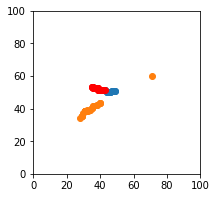

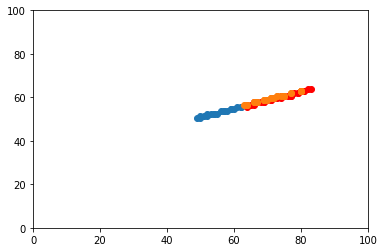

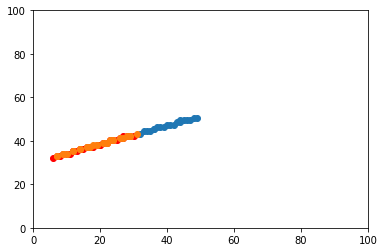

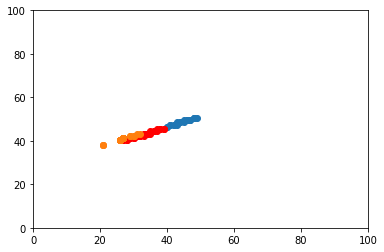

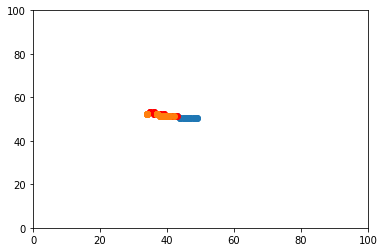

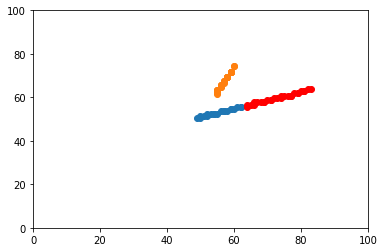

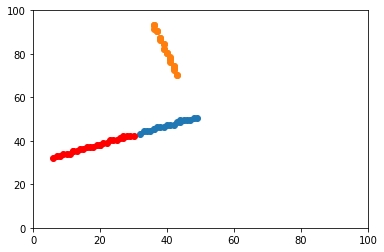

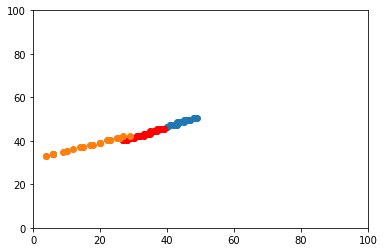

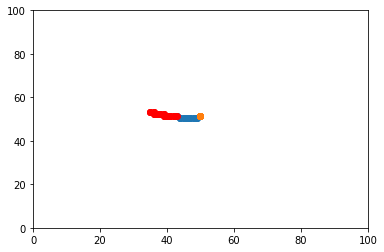

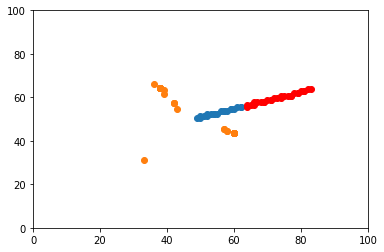

In [311]:
vis_trajectory_scatter()

In [309]:
for num_of_plots in range(1, 10):
        inp_index = 20 * num_of_plots
        ind = 28 * num_of_plots
        print(inp_index, ind)

20 28
40 56
60 84
80 112
100 140
120 168
140 196
160 224
180 252
